# **Dataset Preparation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!gdown https://raw.githubusercontent.com/CUTe-EmbeddedAI/DLCV_Workshop/main/220721_day7/fruit_dataset_exercise.zip 

Downloading...
From: https://raw.githubusercontent.com/CUTe-EmbeddedAI/DLCV_Workshop/main/220721_day7/fruit_dataset_exercise.zip
To: /content/fruit_dataset_exercise.zip
100% 10.6M/10.6M [00:00<00:00, 140MB/s]


In [ ]:
!unzip  fruit_dataset_exercise.zip -d /content/drive/MyDrive/fruit_dataset

Archive:  fruit_dataset_exercise.zip
replace /content/drive/MyDrive/fruit_dataset/train/durian/durian28.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/fruit_dataset/train/durian/durian28.jpg  
  inflating: /content/drive/MyDrive/fruit_dataset/train/durian/durian33.jpg  
  inflating: /content/drive/MyDrive/fruit_dataset/train/pumpkin/0024ef4511cb07be8ccd234b7143304d64899744.jpg  
  inflating: /content/drive/MyDrive/fruit_dataset/train/pumpkin/0066c2ae111450ba6a6ef03486657b58252e6e1f.jpg  
  inflating: /content/drive/MyDrive/fruit_dataset/train/pumpkin/01556c59f720c859217328371036cd6ec1d78732.jpg  
  inflating: /content/drive/MyDrive/fruit_dataset/train/pumpkin/065ae0e728e01e9aacd0c9bc7f37f826ba82fe89.jpg  
  inflating: /content/drive/MyDrive/fruit_dataset/train/pumpkin/083227f662dbc1739041e9e4e1775a049c51606f.jpg  
  inflating: /content/drive/MyDrive/fruit_dataset/train/pumpkin/092d44f61e6d704fc5245a06bc25b80af47b003a.jpg  
  inflating: /content/drive/M

In [ ]:
!rm -rf /content/fruit_dataset_exercise.zip

In [ ]:
%cd /content/drive/MyDrive/fruit_dataset

/content/drive/MyDrive/fruit_dataset


In [2]:
import copy
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from torch.optim import lr_scheduler
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary

Basic Transformation

In [ ]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
train_directory = os.path.join('train')
test_directory = os.path.join('validation')

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

4


In [ ]:
data['train']

Dataset ImageFolder
    Number of datapoints: 521
    Root location: train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
data['test']

Dataset ImageFolder
    Number of datapoints: 323
    Root location: validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=16, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

521
323


In [ ]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'model_'+str(epoch)+'.pt')
            
    return model, history

# **1. Train the dataset using basic model**

In [ ]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_epochs = 30
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/30
Epoch : 000, Training: Loss: 0.8997, Accuracy: 71.4012%, 
		Validation : Loss : 5.1979, Accuracy: 58.5139%, Time: 186.6684s
Epoch: 2/30
Epoch : 001, Training: Loss: 0.5675, Accuracy: 81.5739%, 
		Validation : Loss : 0.9462, Accuracy: 74.3034%, Time: 4.7545s
Epoch: 3/30
Epoch : 002, Training: Loss: 0.3980, Accuracy: 85.7965%, 
		Validation : Loss : 2.1412, Accuracy: 51.3932%, Time: 4.6637s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.3343, Accuracy: 87.7159%, 
		Validation : Loss : 0.5458, Accuracy: 83.2817%, Time: 4.7537s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.3026, Accuracy: 89.4434%, 
		Validation : Loss : 1.1355, Accuracy: 75.8514%, Time: 4.6331s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.3161, Accuracy: 88.0998%, 
		Validation : Loss : 0.7411, Accuracy: 79.8762%, Time: 4.7720s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.3737, Accuracy: 85.0288%, 
		Validation : Loss : 0.7951, Accuracy: 80.4954%, Time: 4.5964s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.2839, Accuracy: 8

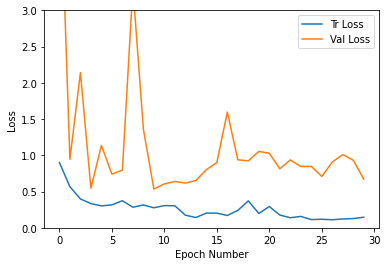

In [ ]:
# Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

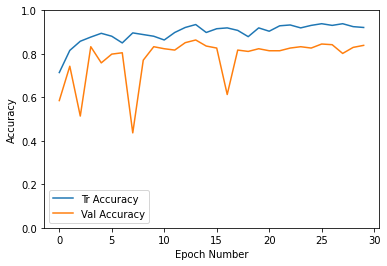

In [ ]:
# Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

#**2. Train on dataset using modification model**

In [ ]:
class MyCustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        resnet18 = models.resnet18(pretrained=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features
        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        self.fc1 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64, eps = 1e-2)
        self.dp = nn.Dropout (0.4)
        self.classifier = nn.Linear(64, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1)
       # and also our new layers. 
        output = self.dp(self.bn1(self.relu(self.fc0(output))))
        output = self.dp(self.bn2(self.relu(self.fc1(output))))
        output = self.classifier(output)
                
        return output
    
model = MyCustomResnet18()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

MyCustomResnet18(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
num_epochs = 30
trained_model, history = train_and_validate(model, criterion, optimizer_ft, num_epochs)

Epoch: 1/30
Epoch : 000, Training: Loss: 1.1589, Accuracy: 62.9559%, 
		Validation : Loss : 1.3756, Accuracy: 62.2291%, Time: 4.6484s
Epoch: 2/30
Epoch : 001, Training: Loss: 0.9553, Accuracy: 69.8656%, 
		Validation : Loss : 1.0394, Accuracy: 71.5170%, Time: 4.5865s
Epoch: 3/30
Epoch : 002, Training: Loss: 0.7418, Accuracy: 76.0077%, 
		Validation : Loss : 1.1218, Accuracy: 75.5418%, Time: 4.6567s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.7120, Accuracy: 80.2303%, 
		Validation : Loss : 0.8918, Accuracy: 70.5882%, Time: 4.8476s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.7490, Accuracy: 77.1593%, 
		Validation : Loss : 0.5707, Accuracy: 82.6625%, Time: 4.7835s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.6302, Accuracy: 80.8061%, 
		Validation : Loss : 0.6588, Accuracy: 79.8762%, Time: 4.7659s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.6324, Accuracy: 81.3820%, 
		Validation : Loss : 1.0131, Accuracy: 75.5418%, Time: 4.7035s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.5288, Accuracy: 84.

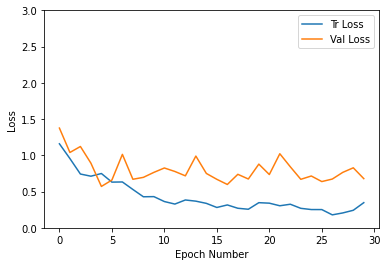

In [ ]:
# Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

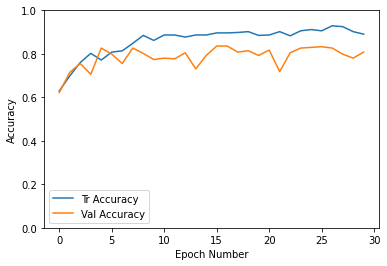

In [ ]:
# Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

# **3. Train dataset after model modification and data modification**

There are 4 classes of data (durian, pumpkin, tomato, and watermelon). The training data is not clean. Few classes are messed up with each other and there are only 2 training data on durian class.
Some modifications to the training dataset:
1.   Increase the durian dataset
2.   Delete mess data on other classes
3.   All data standardize to fit 150 images




Get the data from this google drive link (Add shortcut to your gdrive)
[link text](https://drive.google.com/drive/folders/1M_FX2K001rVj6xi9M72zC0wFhTDXYVK1?usp=sharing)

In [3]:
%cd /content/drive/MyDrive/fruit_dataset_new

/content/drive/MyDrive/fruit_dataset_new


In [4]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [5]:
train_directory = os.path.join('train')
test_directory = os.path.join('validation')

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

4


In [6]:
data['train']

Dataset ImageFolder
    Number of datapoints: 400
    Root location: train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
data['test']

Dataset ImageFolder
    Number of datapoints: 200
    Root location: validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=16, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

400
200


In [9]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'model_'+str(epoch)+'.pt')
            
    return model, history

In [10]:
class MyCustomModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        # axnet = models.alexnet(pretrained=pretrained)
        # self.features = nn.ModuleList(axnet.children())[:-1]
        # self.features = nn.Sequential(*self.features)
        # in_features = axnet.classifier[1].in_features

        resnet18 = models.resnet18(pretrained=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features

        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        # self.fc1 = nn.Linear(256, 64)
        # self.bn2 = nn.BatchNorm1d(64, eps = 1e-2)
        self.dp = nn.Dropout (0.4)
        self.classifier = nn.Linear(256, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1)
       # and also our new layers. 
        output = self.dp(self.bn1(self.relu(self.fc0(output))))
        # output = self.dp(self.bn2(self.relu(self.fc1(output))))
        output = self.classifier(output)
                
        return output
    
model = MyCustomModel()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

MyCustomModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [13]:
num_epochs = 30
trained_model, history = train_and_validate(model, criterion, optimizer_ft, num_epochs)

Epoch: 1/30
Epoch : 000, Training: Loss: 0.6046, Accuracy: 78.2500%, 
		Validation : Loss : 0.1156, Accuracy: 96.0000%, Time: 6.0220s
Epoch: 2/30
Epoch : 001, Training: Loss: 0.1249, Accuracy: 96.0000%, 
		Validation : Loss : 0.1446, Accuracy: 95.5000%, Time: 5.1243s
Epoch: 3/30
Epoch : 002, Training: Loss: 0.0535, Accuracy: 98.7500%, 
		Validation : Loss : 0.1262, Accuracy: 96.0000%, Time: 4.1667s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.0410, Accuracy: 99.2500%, 
		Validation : Loss : 0.1069, Accuracy: 97.0000%, Time: 4.3665s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.0240, Accuracy: 99.5000%, 
		Validation : Loss : 0.0819, Accuracy: 97.5000%, Time: 4.1597s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.0163, Accuracy: 99.5000%, 
		Validation : Loss : 0.0920, Accuracy: 98.0000%, Time: 4.2119s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.0205, Accuracy: 99.5000%, 
		Validation : Loss : 0.0989, Accuracy: 97.5000%, Time: 4.3309s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.0201, Accuracy: 99.

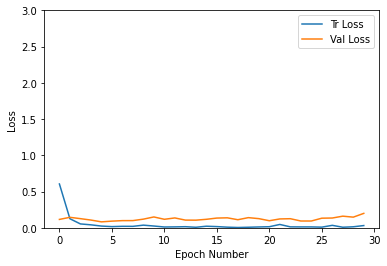

In [14]:
# Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

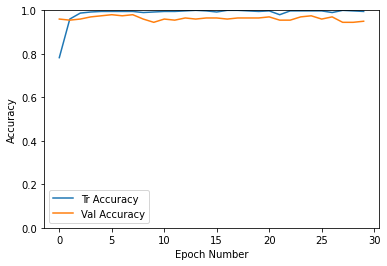

In [15]:
# Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

# **4. Inference on the model with different images**


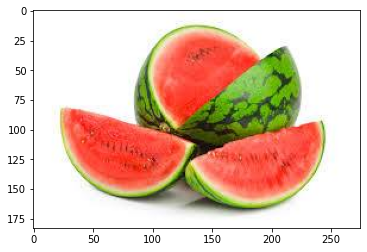

In [20]:
img = cv2.imread("test_watermelon.jpg")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)

In [21]:
# Put our model in eval mode
#model = torch.load("/content/drive/MyDrive/fruit_dataset_new/modelbest.pt")
model.eval()

MyCustomModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [22]:
# Carry out inference

transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
        ])

img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0).to(device)

out = model(batch_t)
print(out.shape)

torch.Size([1, 4])


watermelon 0.999993085861206
pumpkin 3.3822452678577974e-06
durian 2.5587612526578596e-06
tomato 1.0716987617342966e-06


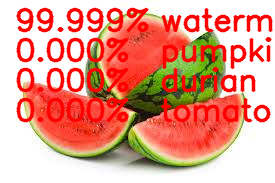

In [23]:
from google.colab.patches import cv2_imshow

classes = ['durian', 'pumpkin', 'tomato', 'watermelon']

# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the top 5 categories that are predicted.
top5_prob, top5_catid = torch.topk(probabilities, 4)

for i in range(top5_prob.size(0)):
    cv2.putText(img, f"{top5_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img, f"{classes[top5_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top5_catid[i]], top5_prob[i].item())
    
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()